In [51]:
from glob import glob
from collections import Counter
from collections import defaultdict

import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import gseapy as gp
import gseapy.plot as gplot

# from scanpy.external.pp import mnn_correct
# from combat.pycombat import pycombat
# import scanorama

In [2]:
def calc_umap(adata, use_rep="X_pca"):
    if use_rep == "X_pca":
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)  # Select top 2000 HVGs
        sc.pp.pca(adata, n_comps=50, mask_var="highly_variable")
        sc.pp.neighbors(adata, n_pcs=50)
        sc.tl.umap(adata)

        print('Created PCA components in .obsm.X_pca')
    
    # Run neighbors and UMAP
    sc.pp.neighbors(adata, use_rep=use_rep, n_neighbors=15)  # Use PCA representation
    sc.tl.umap(adata)
    return adata

def plot_umap(adata, outfile='nano_umap.png'):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Remove frame around each subplot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    sc.pl.umap(adata, color='sample', title='UMAP of all samples', show=False, ax=ax)
    # Modify legend labels to replace "_" with space
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_text(text.get_text().replace("sample", "Sample").replace("_", " "))
    plt.savefig(outfile, dpi=150, bbox_inches='tight')
    plt.show()

# Read and merge data

In [3]:
files = sorted(glob('../data/samples/*.h5ad'))
# Load AnnData objects
adata_list_ann = [sc.read_h5ad(file) for file in files]

In [4]:
path ='../data/'
# Paths for the filtered feature and molecule info files
filtered_feature_paths = [
    "filtered_feature_bc_matrix.h5",
    "filtered_feature_bc_matrix_Sample2.h5",
    "filtered_feature_bc_matrix_Sample3.h5",
    "filtered_feature_bc_matrix_Sample4.h5"
]
# Load each filtered feature file as an AnnData object and add sample ID
adata_list = []
mi_objects = []
for i, ff_path in enumerate(filtered_feature_paths):
    adata = sc.read_10x_h5(path + ff_path) # Load the filtered feature matrix with raw counts and sparse matrix
    adata.var_names_make_unique()
    dict_ann = defaultdict(lambda: 'Other', adata_list_ann[i].obs['predicted.celltype'].to_dict())
    adata.obs.loc[:, 'predicted.celltype'] = adata.obs.index.map(dict_ann)
    # Add the AnnData object to the list
    adata_list.append(adata)
    # display(anndata_objects[i-1].var.index)

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not un

In [5]:
sample_names = ['Sample 1 - 40 nm NPs', 'Sample 2 - 200 nm NPs', 'Sample 3 - 40 + 200 nm NPs', 'Sample 4 - control']
samples = []
for i, adata in enumerate(adata_list):
    sample = f'sample_{i+1}'
    adata.obs['sample'] = sample # Add a column 'sample' to keep track of the sample source
    adata.obs.index = [f"{f'sample_{i+1}'}_{x}" for x in adata.obs.index]  # Modify the index to be unique
    samples.append(sample)
# Merge all AnnData objects
merged_adata =  ad.concat(adata_list, axis=0, join='inner')  # adata_list[0].concatenate(adata_list[1:], join='inner', index_unique=None)
merged_adata.write_h5ad('../data/merged.h5ad', compression='gzip')

In [7]:
merged_adata

<34168x32738 sparse matrix of type '<class 'numpy.float32'>'
	with 78090568 stored elements in Compressed Sparse Row format>

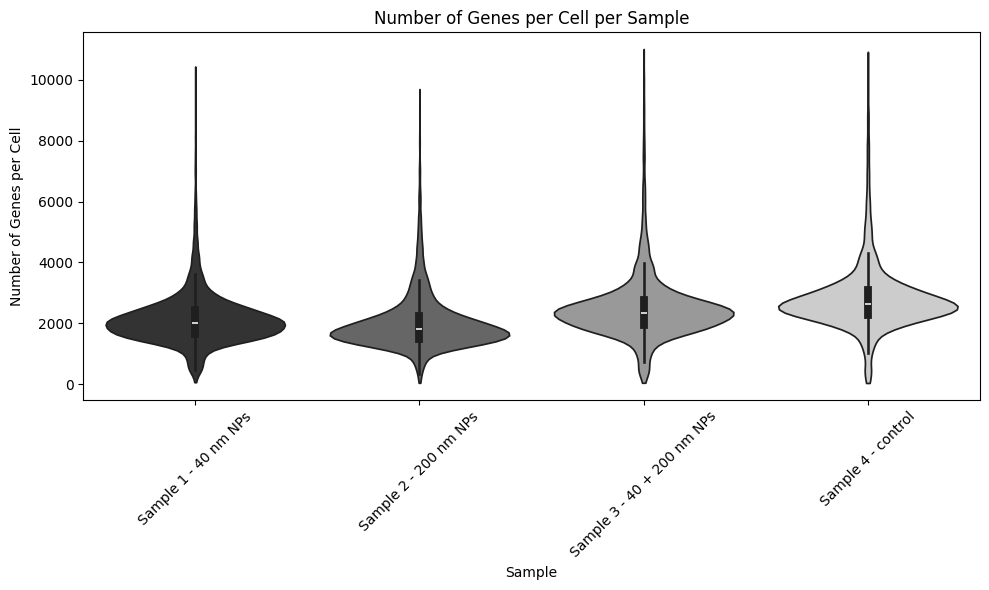

In [8]:
# Combine data into a single DataFrame for visualization
qc_data = []

for adata, sample_name in zip(adata_list, sample_names):
    # Calculate the number of genes per cell
    adata.obs['n_genes_per_cell'] = (adata.X > 0).sum(axis=1)  # For sparse matrix compatibility
    qc_data.append(pd.DataFrame({'Sample': sample_name, 'n_genes_per_cell': adata.obs['n_genes_per_cell']}))

# Combine QC data from all samples
qc_df = pd.concat(qc_data, ignore_index=True)

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=qc_df, x='Sample', hue='Sample', y='n_genes_per_cell', inner='box', palette='grey', cut=0)

# Customize the plot
plt.title('Number of Genes per Cell per Sample')
plt.ylabel('Number of Genes per Cell')
plt.xlabel('Sample')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('nano_h5_qc.png', dpi=150, bbox_inches='tight')
# Show the plot
plt.show()


In [15]:
# H5 files
# Calculate QC metrics for each AnnData object
for adata in adata_list:
    sc.pp.calculate_qc_metrics(adata, inplace=True)

# Access the results
for sample_name, adata in zip(samples, adata_list):
    print(f"{sample_name} - Number of genes per cell statistics:")
    print(f"Min: {adata.obs['n_genes_by_counts'].min()}")
    print(f"Max: {adata.obs['n_genes_by_counts'].max()}")
    print(f"Mean: {adata.obs['n_genes_by_counts'].mean()}")

sample_1 - Number of genes per cell statistics:
Min: 64
Max: 10437
Mean: 2136.111403408441
sample_2 - Number of genes per cell statistics:
Min: 44
Max: 9696
Mean: 2018.9369440289695
sample_3 - Number of genes per cell statistics:
Min: 46
Max: 11012
Mean: 2491.6232189119173
sample_4 - Number of genes per cell statistics:
Min: 39
Max: 10919
Mean: 2807.7795600366635


# Cell annotation overview

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


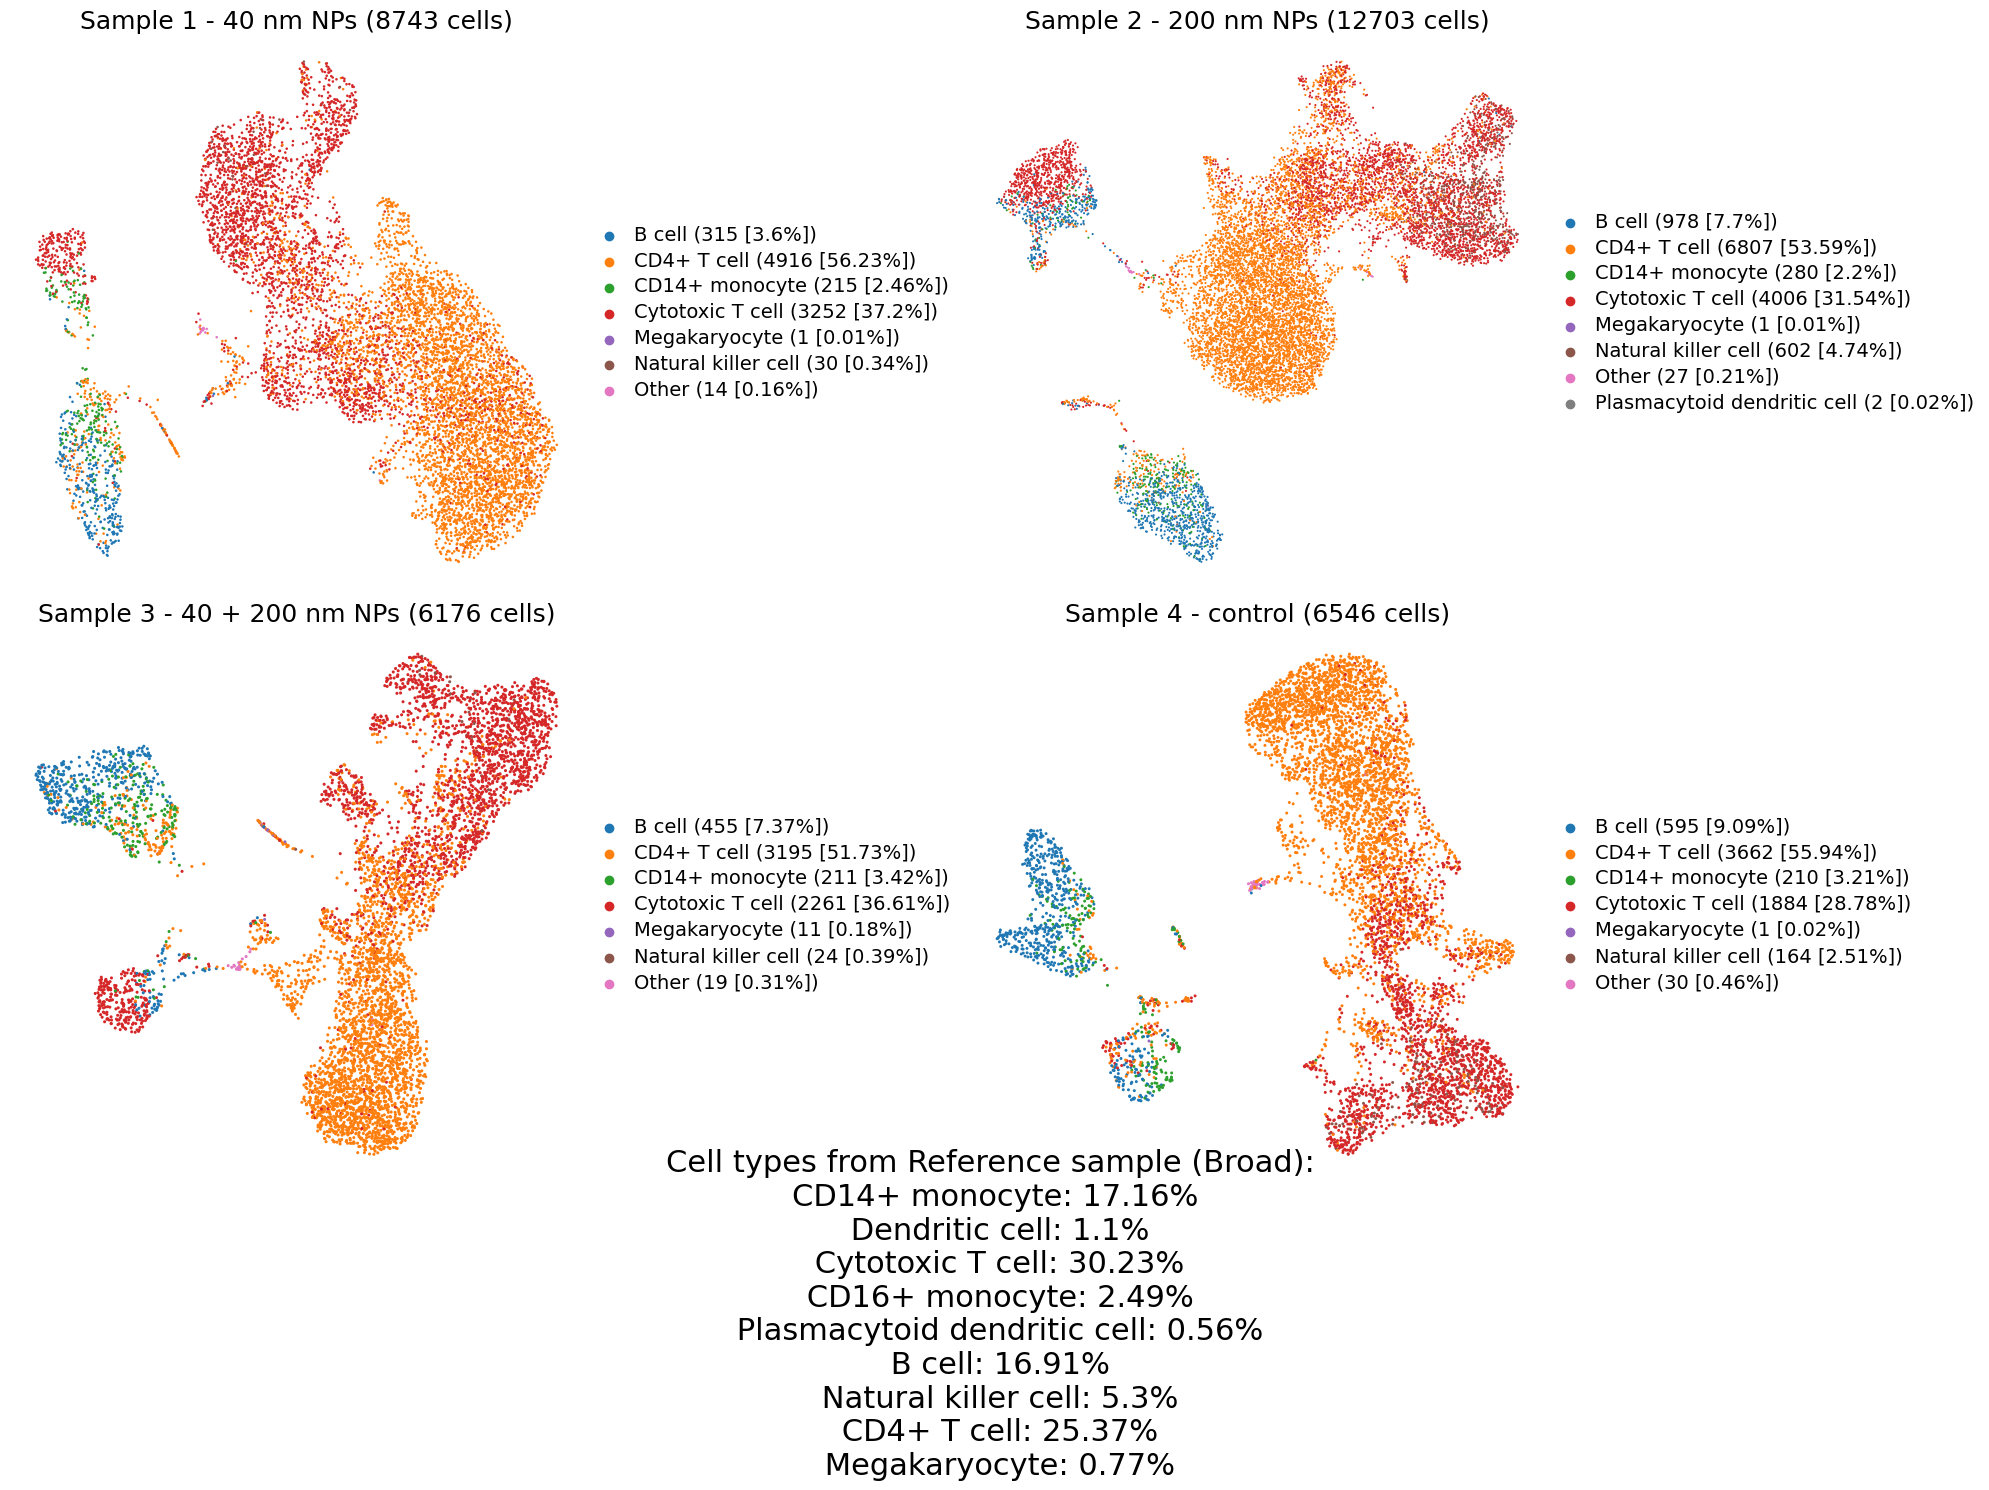

In [9]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()
cell_type_col = "predicted.celltype"  # Annotation column name
adata_ref = sc.read_h5ad('../data/ref_broad_pbmc/sc.h5ad')

for i, (adata, ax) in enumerate(zip(adata_list, axes)):
    # Calculate cell type counts and percentages

    cell_counts = adata.obs[cell_type_col].value_counts()
    total_cells = cell_counts.sum()
    percentages = (cell_counts / total_cells * 100).round(2)
    
    # Modify categories to include counts and percentages
    updated_categories = [
        f"{cell_type} ({count} [{percentage}%])"
        for cell_type, count, percentage in zip(cell_counts.index, cell_counts, percentages)
    ]
    mapping = dict(zip(cell_counts.index, updated_categories)) 
    adata.obs[cell_type_col + "_updated"] = adata.obs[cell_type_col].map(mapping)#.fillna("Unknown")

    if 'X_umap' not in adata.obsm.keys():
        # Step 1: Normalize and Log Transform
        sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize counts per cell
        sc.pp.log1p(adata)  # Log-transform the data
        
        # Step 2: Identify Highly Variable Genes
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var['highly_variable']]  # Subset to HVGs
        
        # Step 3: Scale the Data
        sc.pp.scale(adata, max_value=10)  # Standardize the data
        
        # Step 4: PCA
        sc.tl.pca(adata, n_comps=50)
        
        # Step 5: Compute the Neighbors Graph
        sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)  # Use first 20 PCs
        
        # Step 6: Compute UMAP
        sc.tl.umap(adata)

    # Plot UMAP
    sc.pl.umap(
        adata,
        color=cell_type_col + "_updated",
        ax=ax,
        show=False,
        title=sample_names[i],
        legend_loc="right margin"
    )
    ax.set_title(f'{sample_names[i]} ({len(adata)} cells)', size=18)
    # Remove frame around each subplot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    # Increase the legend font size
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_fontsize(14)  # Adjust the font size
    ax.set_xlabel(None)
    ax.set_ylabel(None)


# Add a horizontal legend at the bottom of the figure with reference cell types
# Define legend items and title
data = Counter(adata_ref.obs['CellType'])
total = sum(data.values())
# percentages = {key: np.round(value / total, 2) * 100 for key, value in data.items()}
legend_items = [f'{key}: {np.round(value / total * 100, 2)}' for key, value in data.items() if not str(key) in ['Unassigned', 'nan']]

fig.text(
    0.5, -0.1,  # Position: centered horizontally, slightly below the figure
    "Cell types from Reference sample (Broad): \n" + "%\n ".join(legend_items) + '%',  # Legend text
    ha='center', va='center', fontsize=22  # Alignment and font size
)

# Adjust layout and display
plt.tight_layout()
plt.savefig('nano_h5.png', dpi=150, bbox_inches='tight')
plt.show()


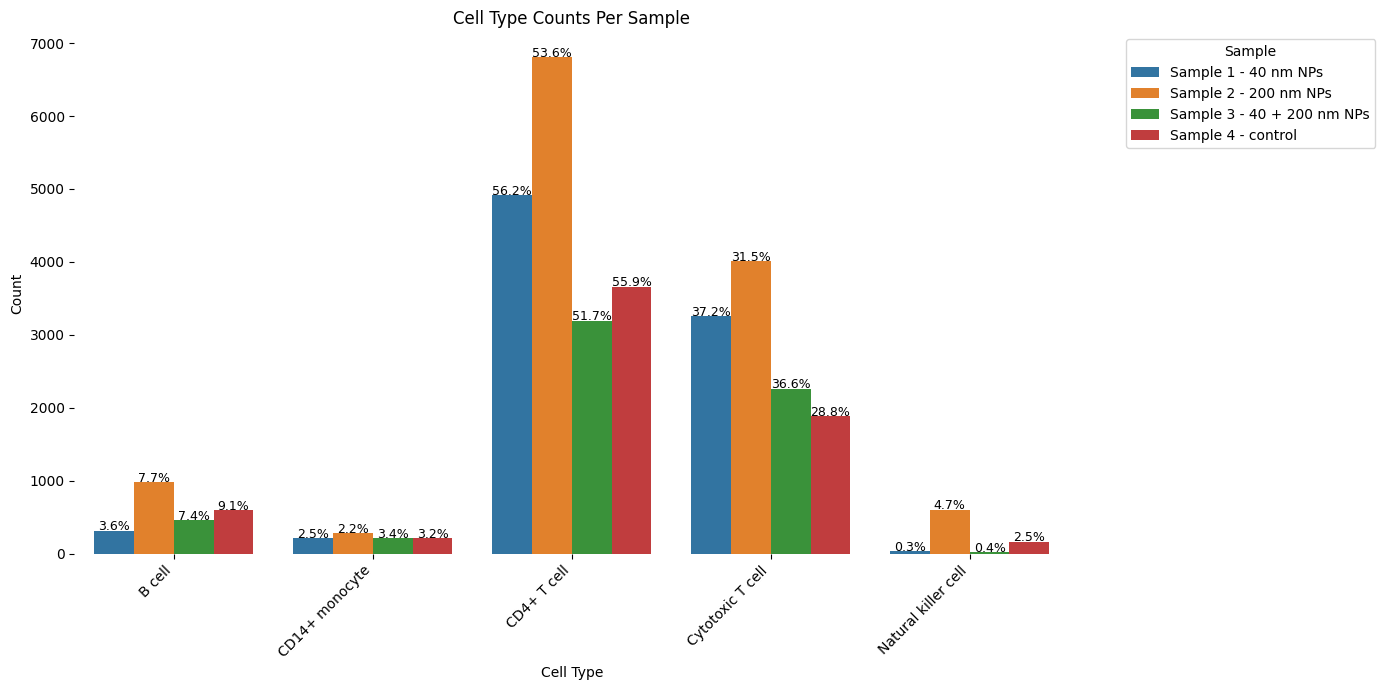

In [10]:
# Define the specific cell types to include in the plot
cell_types_to_plot = ['B cell', 'CD14+ monocyte', 'CD4+ T cell', 'Cytotoxic T cell', 'Natural killer cell']

# Combine the data from adata_list into a single DataFrame
data = []
for i, adata in enumerate(adata_list):
    sample_name = f"Sample {i+1}"
    total_cells = len(adata)  # Total cells in the sample
    celltype_counts = adata.obs['predicted.celltype'].value_counts()
    for celltype in cell_types_to_plot:
        count = celltype_counts.get(celltype, 0)  # Get count or 0 if cell type is absent
        percentage = (count / total_cells) * 100
        data.append({'Sample': sample_names[i], 'Cell Type': celltype, 'Count': count, 'Percentage': percentage})

# Create a DataFrame for plotting
df = pd.DataFrame(data)

# Set up the plot
plt.figure(figsize=(14, 7))
sns.barplot(data=df, x='Cell Type', y='Count', hue='Sample', palette='tab10')

# Annotate the plot with percentages
for bar, percentage in zip(plt.gca().patches, df['Percentage']):
    height = bar.get_height()
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,  # Position above the bar
        f"{percentage:.1f}%",
        ha="center",
        fontsize=9,
        color="black"
    )

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.title('Cell Type Counts Per Sample')
plt.ylabel('Count')
plt.xlabel('Cell Type')
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.box(None)

# Show the plot
plt.savefig('nano_ct_per_sample_h5.png', dpi=150, bbox_inches='tight')
plt.show()


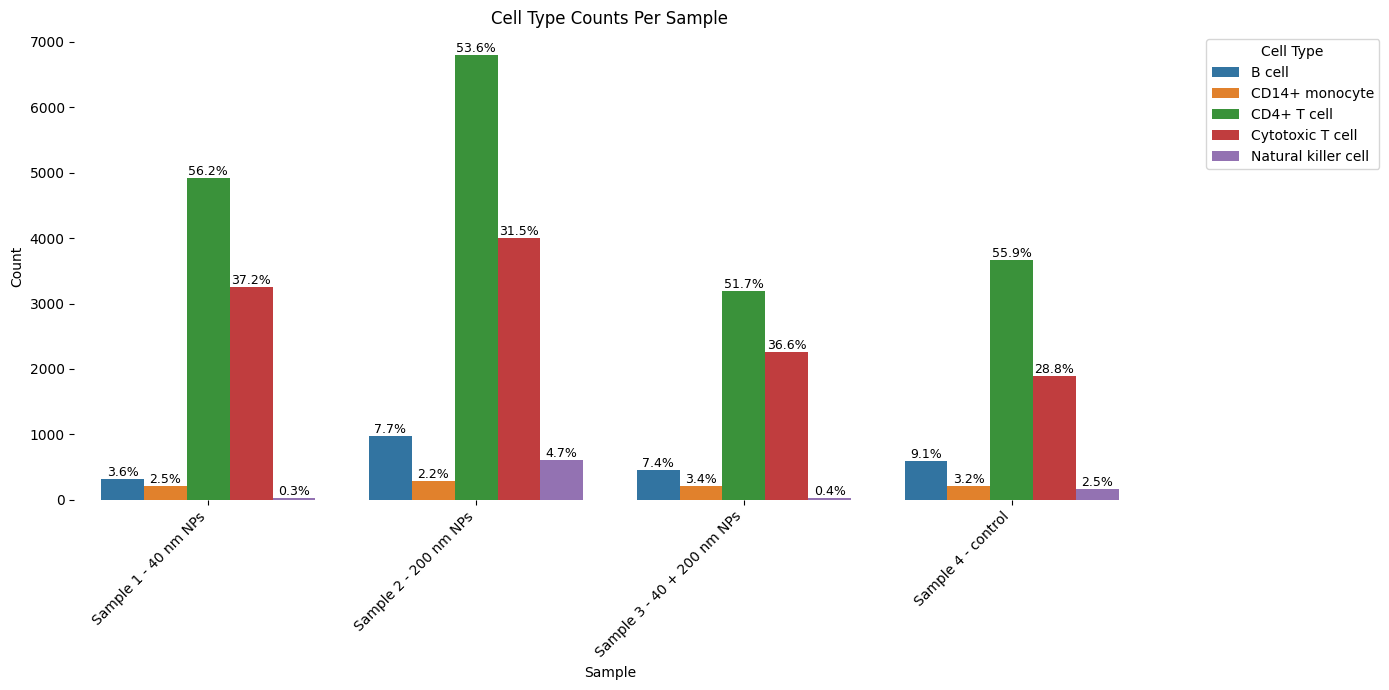

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the specific cell types to include in the plot
cell_types_to_plot = ['B cell', 'CD14+ monocyte', 'CD4+ T cell', 'Cytotoxic T cell', 'Natural killer cell']

# Combine the data from adata_list into a single DataFrame
data = []
for i, adata in enumerate(adata_list):
    sample_name = f"Sample {i+1}"
    total_cells = len(adata)  # Total cells in the sample
    celltype_counts = adata.obs['predicted.celltype'].value_counts()
    for celltype in cell_types_to_plot:
        count = celltype_counts.get(celltype, 0)  # Get count or 0 if cell type is absent
        percentage = (count / total_cells) * 100
        data.append({'Sample': sample_names[i], 'Cell Type': celltype, 'Count': count, 'Percentage': percentage})

# Create a DataFrame for plotting
df = pd.DataFrame(data)

# Set up the plot with samples on the x-axis and cell types grouped
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=df, x='Sample', y='Count', hue='Cell Type', palette='tab10')

# Annotate the plot with percentages
for container, cell_type in zip(ax.containers, cell_types_to_plot):
    for bar, percentage in zip(container, df[df['Cell Type'] == cell_type]['Percentage']):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 1,  # Position above the bar
            f"{percentage:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
            color="black"
        )

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.title('Cell Type Counts Per Sample')
plt.ylabel('Count')
plt.xlabel('Sample')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.box(False)
plt.savefig('nano_sample_per_ct_h5.png', dpi=150, bbox_inches='tight')

# Show the plot
plt.show()


# Umap

Created PCA components in .obsm.X_pca


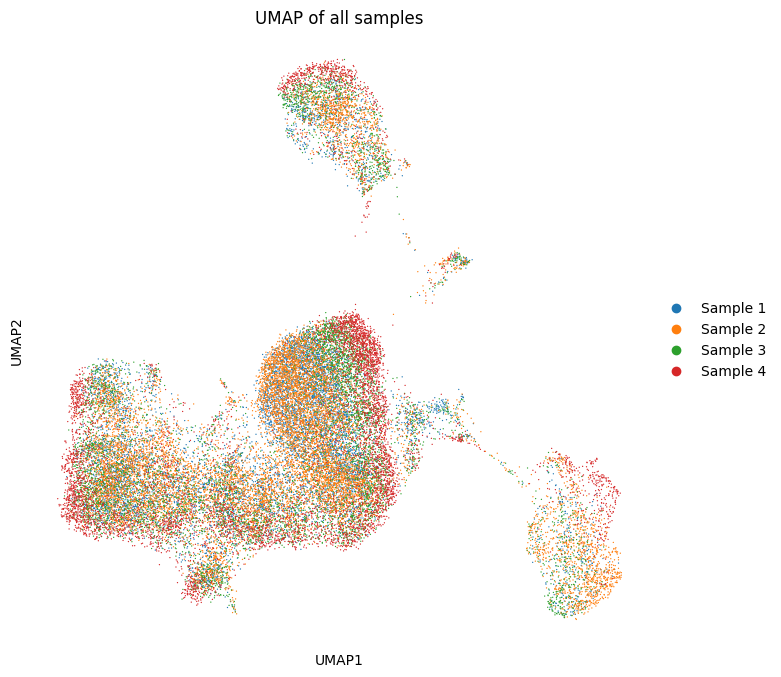

In [12]:
adata_umap = calc_umap(merged_adata.copy())
plot_umap(adata_umap) # No need to remove batch effects!

# Batch effects correction - pycombat

In [4]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')

samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

# before = adata_combined.X.copy()
# sc.pp.combat(adata_combined, key='sample', inplace=True)

df_expression = pd.DataFrame(adata_combined.X.toarray(), index=adata_combined.obs.index, columns=adata_combined.var.index).T
# run pyComBat
df_corrected = pycombat(df_expression, adata_combined.obs['sample'].values)


# after = df_corrected
# print((before != after).sum())  # Count changes


Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created PCA components in .obsm.X_pca


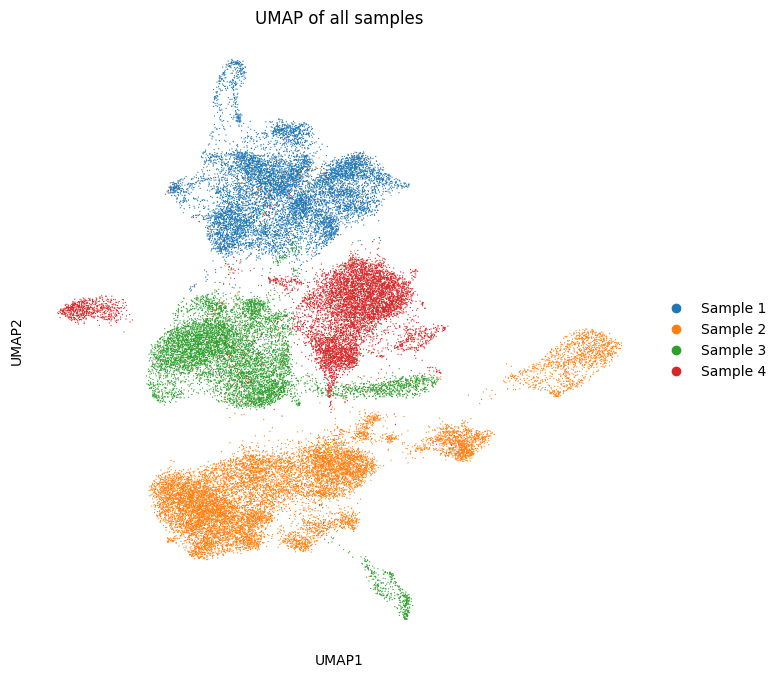

In [7]:
adata_corrected = adata_combined.copy()
adata_corrected.X = df_corrected.T.values
adata_corr_umap = calc_umap(adata_corrected)
plot_umap(adata_corr_umap)

# Batch effects correction - scanpy pycombat x4

837100000


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


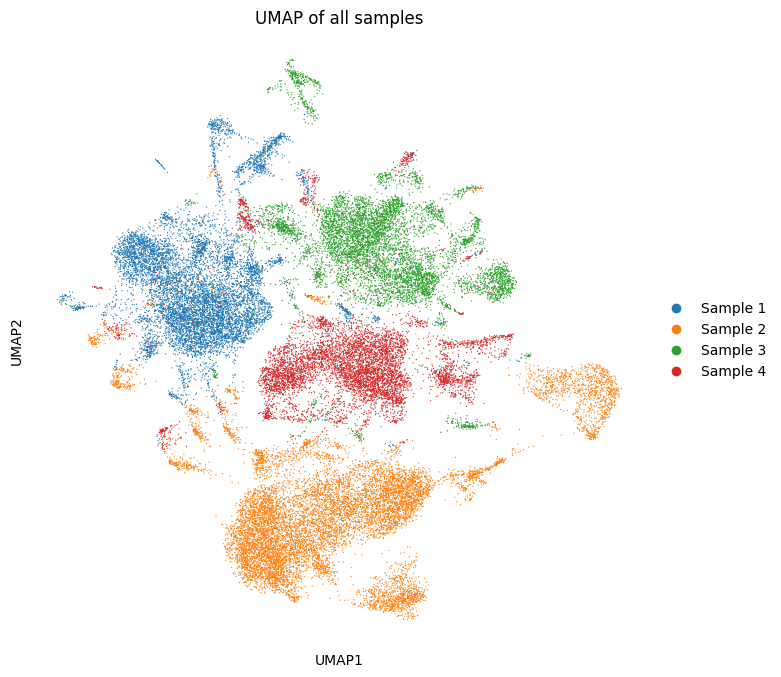

In [23]:
# 4 times

adata_combined = sc.read_h5ad('../data/merged.h5ad')
samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

before = adata_combined.X.copy()
for i in range(4):
    sc.pp.combat(adata_combined, key='sample', inplace=True)
after = adata_combined.X
print((before != after).sum())  # Count changes
adata_corr_umap2 = calc_umap(adata_combined)
plot_umap(adata_corr_umap2)

# Batch effects correction - scanpy scanorama

In [16]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')

samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

before = adata_combined.X
corrected_data_list = scanorama.correct_scanpy(adata_list, return_dimred=True)  # output will contain .obsm['X_scanorama']
# after = adata_combined.X
# print((before != after).sum())  # Count changes
adata_corrected = ad.concat(corrected_data_list) # Reconstruct the AnnData object
after = adata_corrected.X
print((before != after).sum())  # Count changes

Found 22000 genes among all datasets
[[0.         0.00413311 0.00979541 0.0023315 ]
 [0.         0.         0.         0.00252257]
 [0.         0.         0.         0.016739  ]
 [0.         0.         0.         0.        ]]


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value


152102972


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


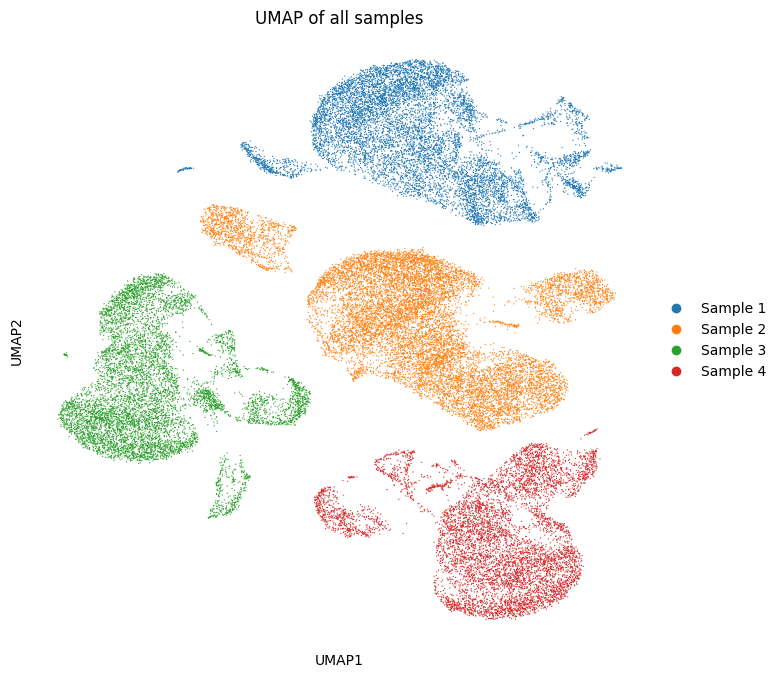

In [17]:
adata_corr_umap3 = calc_umap(adata_corrected)
plot_umap(adata_corr_umap3)

# Batch effects correction - scanpy MNN correct

In [ ]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')

samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

before = adata_combined.X
adata_mnn_corrected, corrected_batches = mnn_correct(*adata_list, batch_key='batch')
# after = adata_combined.X
after = adata_corrected.X
print((before != after).sum())  # Count changes
adata_corr_umap3 = calc_umap(adata_corrected)
plot_umap(adata_corr_umap3)

# Batch effects correction - scanpy pycombat - no normalisation

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


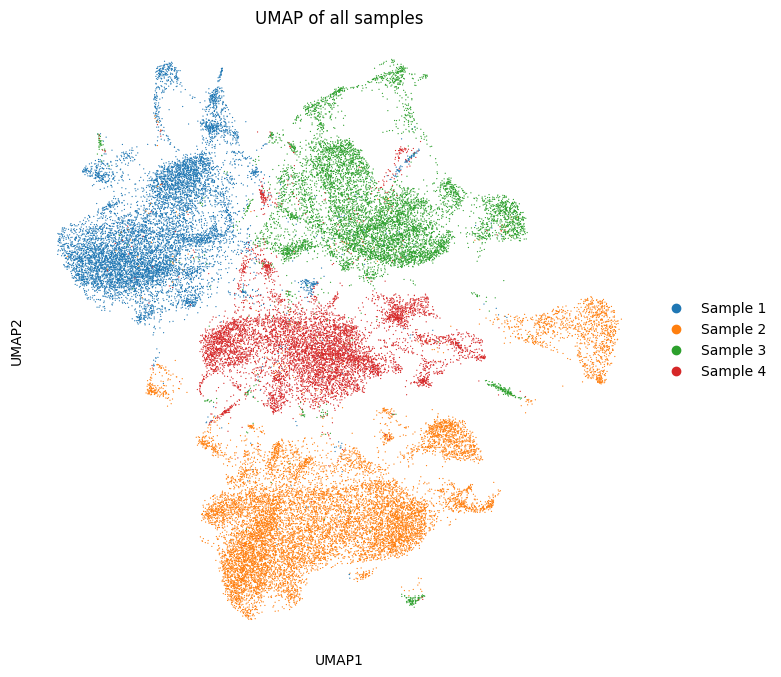

In [25]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')
samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]
adata_corrected = adata_combined.copy()
sc.pp.combat(adata_corrected, key='sample', inplace=True)
adata_corr_umap = calc_umap(adata_corrected)
plot_umap(adata_corr_umap)

# Batch effects correction - scanpy pycombat - with normalisation

In [ ]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')
# Normalize and log-transform the raw counts
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)
samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]
adata_corrected = adata_combined.copy()
sc.pp.combat(adata_corrected, key='sample', inplace=True)
adata_corr_umap = calc_umap(adata_corrected.copy())
plot_umap(adata_corr_umap, 'umap_corr.png')
# adata_corrected.write_h5ad('../data/merged_batch_corrected.h5ad', compression='gzip')

In [117]:
Counter(merged_adata.obs['predicted.celltype'])

Counter({'CD4+ T cell': 21564,
         'Cytotoxic T cell': 12202,
         'B cell': 2449,
         'CD14+ monocyte': 996,
         'Natural killer cell': 821,
         'Megakaryocyte': 15,
         'Plasmacytoid dendritic cell': 3})

# Differential expression

In [13]:
weight_pow_thr = 0.5
cell_type_count_dict = {} # Used for penalizing pval adj
for i, sample in enumerate(samples):
    cnt = Counter(adata_list[i].obs['predicted.celltype'])
    cell_type_count_dict[sample] = cnt
    
# Subset for the four cell types of interest
cell_types = ['B cell', 'CD14+ monocyte', 'CD4+ T cell', 'Cytotoxic T cell', 'Natural killer cell']
adata_subset = merged_adata[merged_adata.obs['predicted.celltype'].isin(cell_types)].copy()
# Normalize and log-transform the raw counts
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)

# Perform DE analysis for each cell type
results_all_degs = {ct: dict() for ct in cell_types}
results_significant_degs = {ct: dict() for ct in cell_types}
results_top_degs = {ct: dict() for ct in cell_types}
for cell_type in cell_types:
    cell_type_data = adata_subset[adata_subset.obs['predicted.celltype'] == cell_type]
    for sample in ['sample_1', 'sample_2', 'sample_3']:

        cell_type_data_sample = cell_type_data[cell_type_data.obs['sample'].isin([sample, 'sample_4'])]
        # sample_size = len(cell_type_data_sample[cell_type_data_sample.obs['sample'] == sample])
    
        # Perform DE analysis
        sc.tl.rank_genes_groups(cell_type_data_sample, groupby='sample', reference='sample_4', method='wilcoxon', pts=True)
    
        # Store results
        # Filter genes with significant adjusted p-value
        degs_df = sc.get.rank_genes_groups_df(cell_type_data_sample, group=sample)
        # Add penalty depending on the number of cells: 
        
        degs_df.loc[:, 'pvals_adj_weighted'] = degs_df['pvals_adj'] * np.pow(cell_type_count_dict[sample].most_common(1)[0][1],weight_pow_thr) / \
            np.pow(cell_type_count_dict[sample][cell_type], weight_pow_thr) 
        degs_df = degs_df[~degs_df['logfoldchanges'].isna()]
        degs_df.loc[:, 'logfoldchanges_abs'] = degs_df['logfoldchanges'].apply(abs)
        degs_df = degs_df.sort_values(by='logfoldchanges_abs', ascending=False) # Sort by log fold change or adjusted p-value
        # Remove inf and -inf logfolds
        nan_df = degs_df[degs_df.isin([float('inf'), float('-inf'), float('nan')]).any(axis=1)]
        if len(nan_df > 0):
            print(nan_df)
            degs_df = degs_df.replace([float('inf'), float('-inf'), float('-inf'), float('nan')], None).dropna()
        
        significant_degs = degs_df[degs_df['pvals_adj'] < 0.05]  # Adjust threshold as needed
        top_degs = significant_degs[(significant_degs['logfoldchanges_abs'] > 1) ]

        results_all_degs[cell_type][sample] = degs_df
        results_significant_degs[cell_type][sample] = significant_degs
        results_top_degs[cell_type][sample] = top_degs
        print(len(significant_degs), len(top_degs))

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


1949 397


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


2962 295


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


838 104


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


1370 427


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


2851 715


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


1032 569


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


6561 157


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


7573 256


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


1788 22


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


3203 183


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


4844 728


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


1401 155


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


4 3


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


350 105


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


3 2


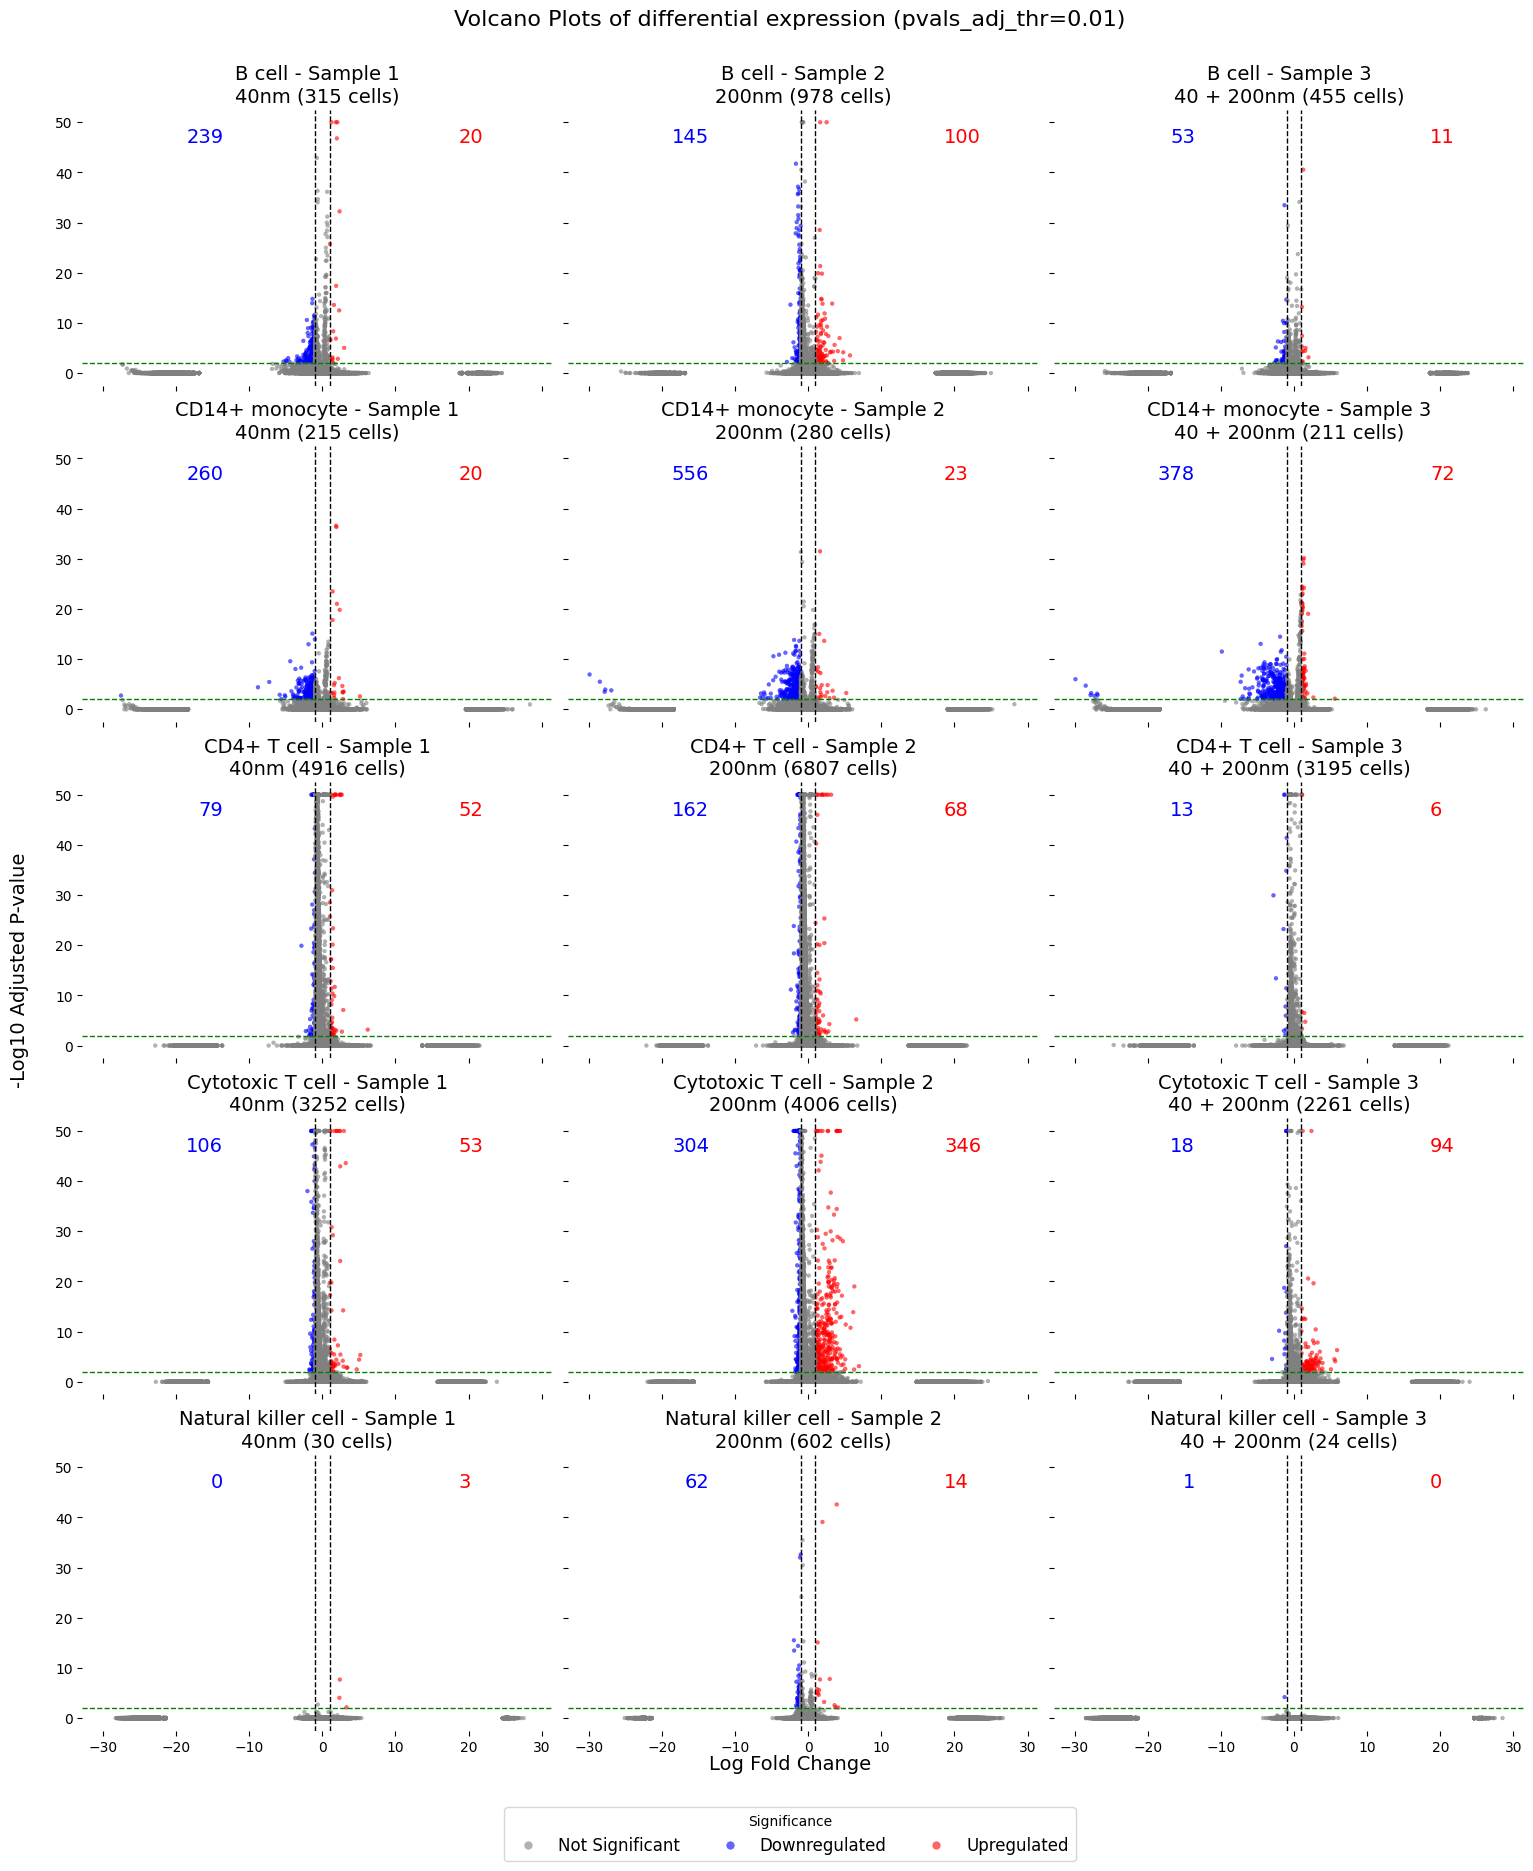

In [37]:
# Define thresholds for significant DEGs
logFC_threshold = 1
adj_p_value_threshold = 0.01
pval_adj_var = 'pvals_adj'

# Data structure keys
cell_types = list(results_all_degs.keys())
samples_desc = ['Sample 1\n40nm', 'Sample 2\n200nm', 'Sample 3\n40 + 200nm']

# Create a grid of subplots based on the dimensions of the data
n_rows = len(cell_types)
n_cols = len(samples_desc)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True, sharey=True)

# Iterate through cell types and samples
for i, cell_type in enumerate(cell_types):
    for j, sample in enumerate(samples_desc):
        ax = axes[i, j]
        
        # Access the dataframe for the current cell type and sample
        df = results_all_degs[cell_type][f"sample_{j + 1}"]
        
        # Add a column to classify genes based on thresholds
        df['significance'] = 'Not Significant'
        df.loc[((df['logfoldchanges'] >= logFC_threshold) & (df[pval_adj_var] < adj_p_value_threshold)), 'significance'] = 'Upregulated'
        df.loc[((df['logfoldchanges'] <= -logFC_threshold) & (df[pval_adj_var] < adj_p_value_threshold)), 'significance'] = 'Downregulated'
        df.loc[:, pval_adj_var] = df[pval_adj_var].apply(lambda x: x if x > 1e-50 else 1e-50)
        
        # Create the volcano plot for this subplot
        sns.scatterplot(
            data=df,
            x='logfoldchanges', 
            y=-np.log10(df[pval_adj_var]), 
            hue='significance',
            palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'},
            alpha=0.6,
            s=8,
            edgecolor=None,
            ax=ax
        )
        
        # Add threshold lines
        ax.axvline(x=logFC_threshold, color='black', linestyle='--', linewidth=1)
        ax.axvline(x=-logFC_threshold, color='black', linestyle='--', linewidth=1)
        ax.axhline(y=-np.log10(adj_p_value_threshold), color='green', linestyle='--', linewidth=1)
        
        # Set subplot title to include current cell type and sample
        num_cells = len(adata_list[j][adata_list[j].obs['predicted.celltype'] == cell_type])
        ax.set_title(f"{cell_type} - {sample} ({num_cells} cells)", fontsize=14)
        ax.get_legend().remove()
        
        # Remove x and y labels for subplots
        ax.set_xlabel("")
        ax.set_ylabel("")

        # Remove frame around each subplot
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        
        # Annotate the number of upregulated and downregulated genes
        # Count the number of upregulated and downregulated genes
        upregulated_count = len(df[df['significance'] == 'Upregulated'])
        downregulated_count = len(df[df['significance'] == 'Downregulated'])
        ax.text(
            0.3, 0.9, f"{downregulated_count}", 
            color='blue', va='center', ha='right', fontsize=14,
            transform=ax.transAxes  # Use axes coordinates for consistent positioning
        )
        ax.text(
            0.8, 0.9, f"{upregulated_count}", 
            color='red', va='center', ha='left', fontsize=14,
            transform=ax.transAxes  # Use axes coordinates for consistent positioning
        )

# Add main x and y labels with adjusted positions
fig.text(0.5, 0.1, 'Log Fold Change', ha='center', fontsize=14)
fig.text(-0.02, 0.5, '-Log10 Adjusted P-value', va='center', rotation='vertical', fontsize=14)

# Adjust layout and add a single legend below the figure
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title='Significance', loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 0.05), markerscale=2)

plt.tight_layout(rect=[0, 0.1, 1, 0.96])  # Adjust lower space for legend
plt.suptitle(f"Volcano Plots of differential expression ({pval_adj_var}_thr={adj_p_value_threshold})", fontsize=16)
plt.savefig(f'volcano_h5_{pval_adj_var}_{weight_pow_thr}.png', dpi=200, bbox_inches='tight')
plt.show()


2343


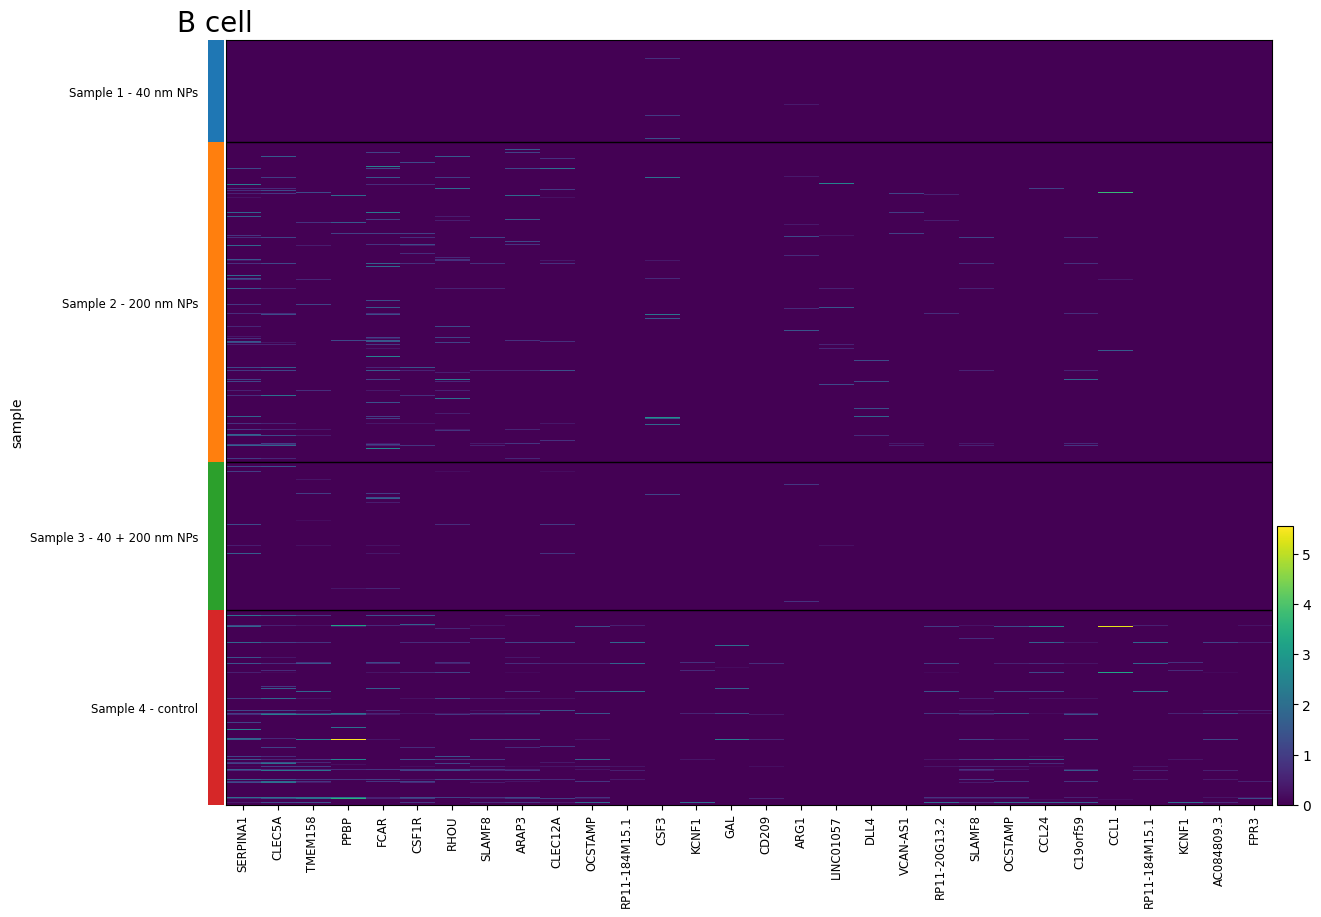

916


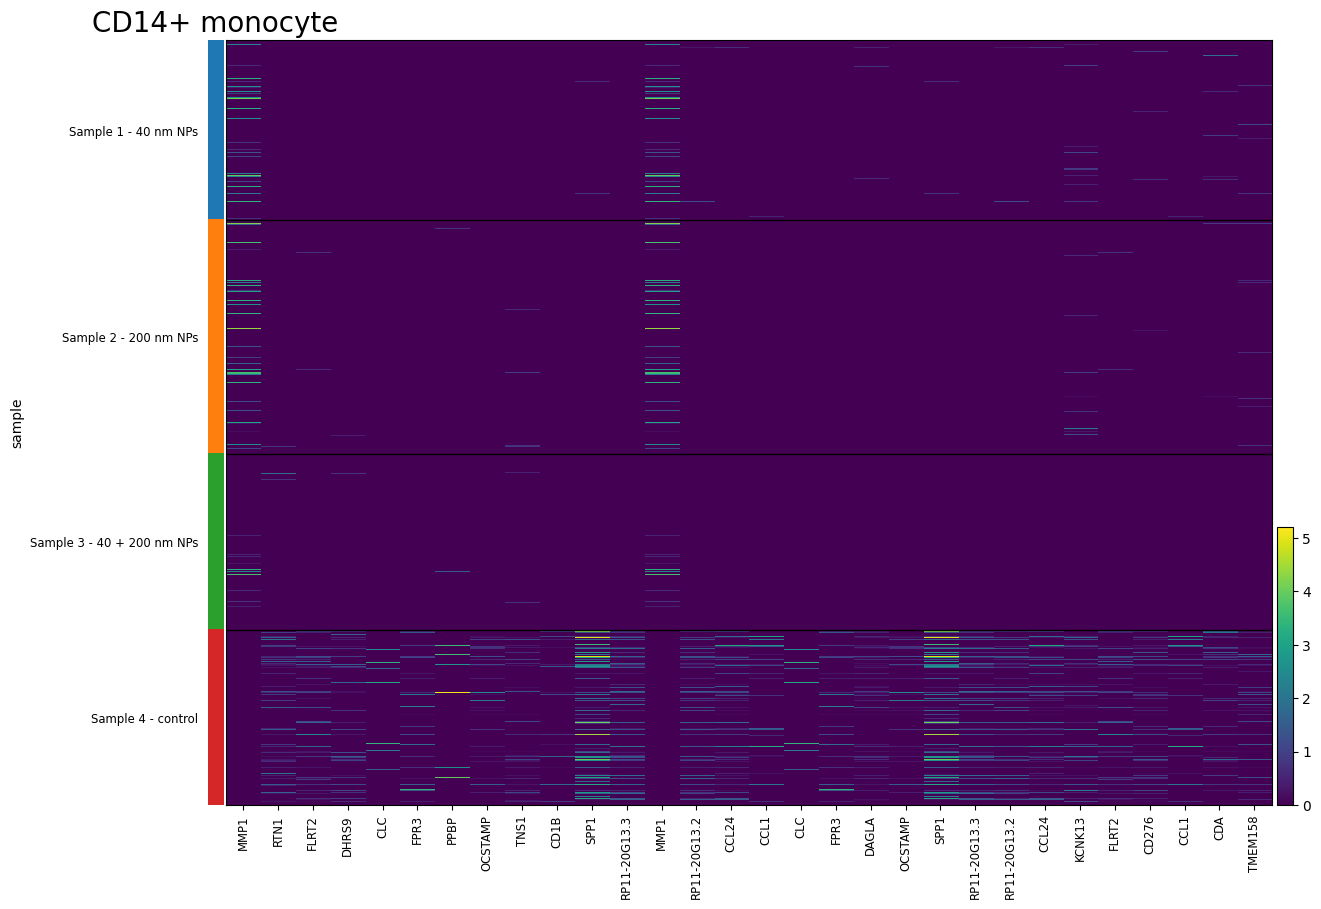

18580


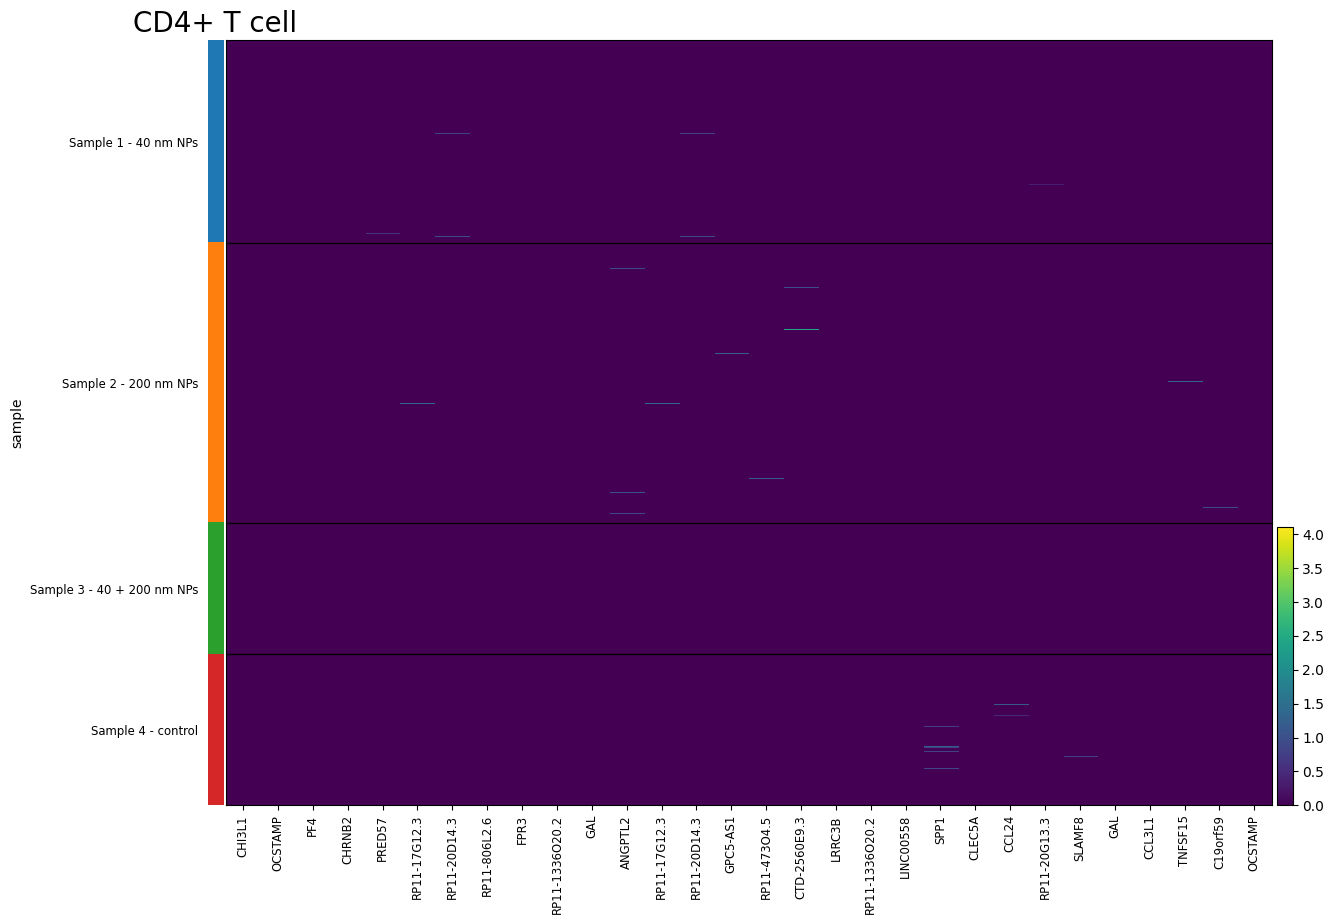

11403


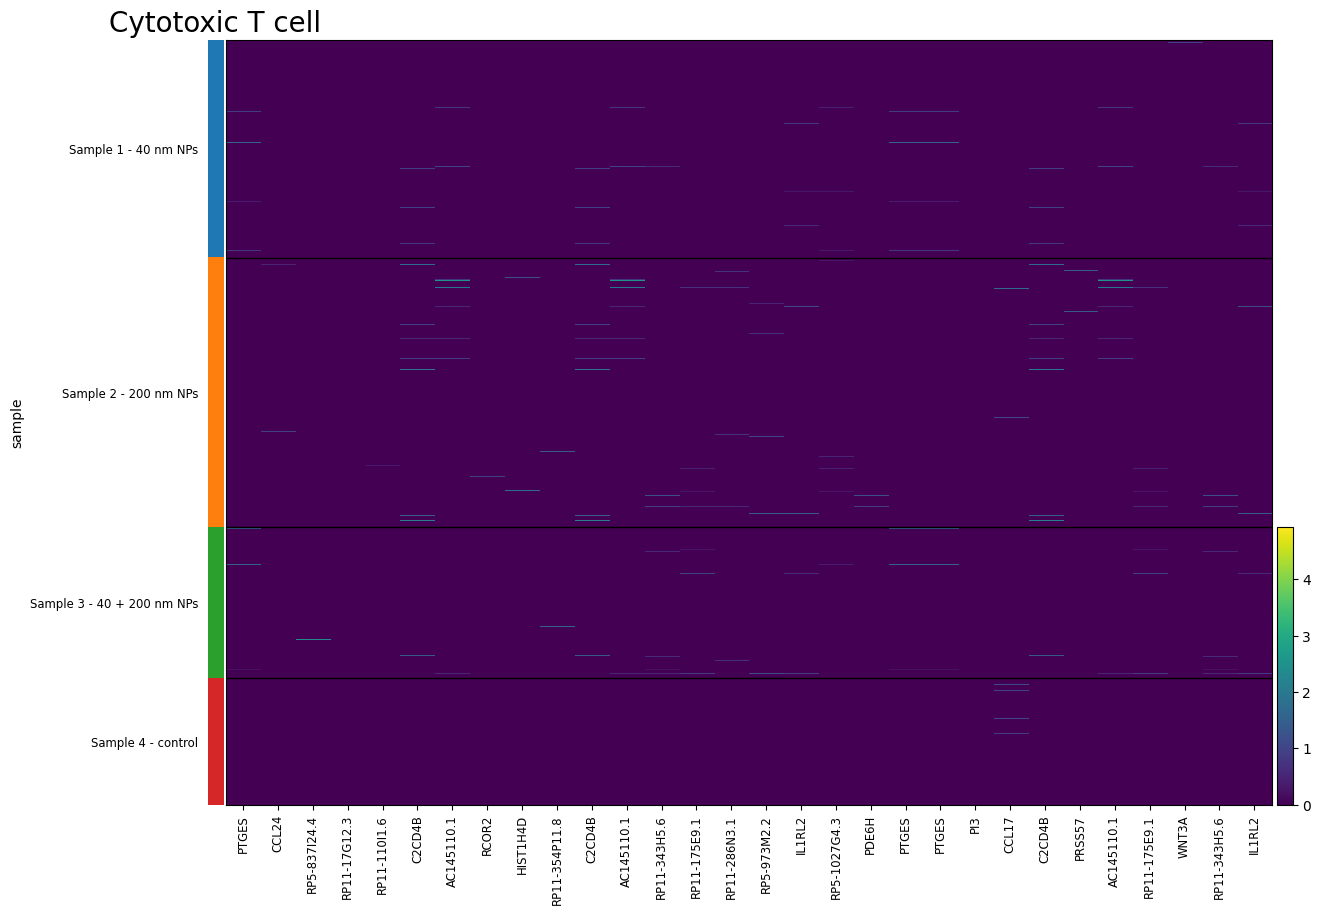

820


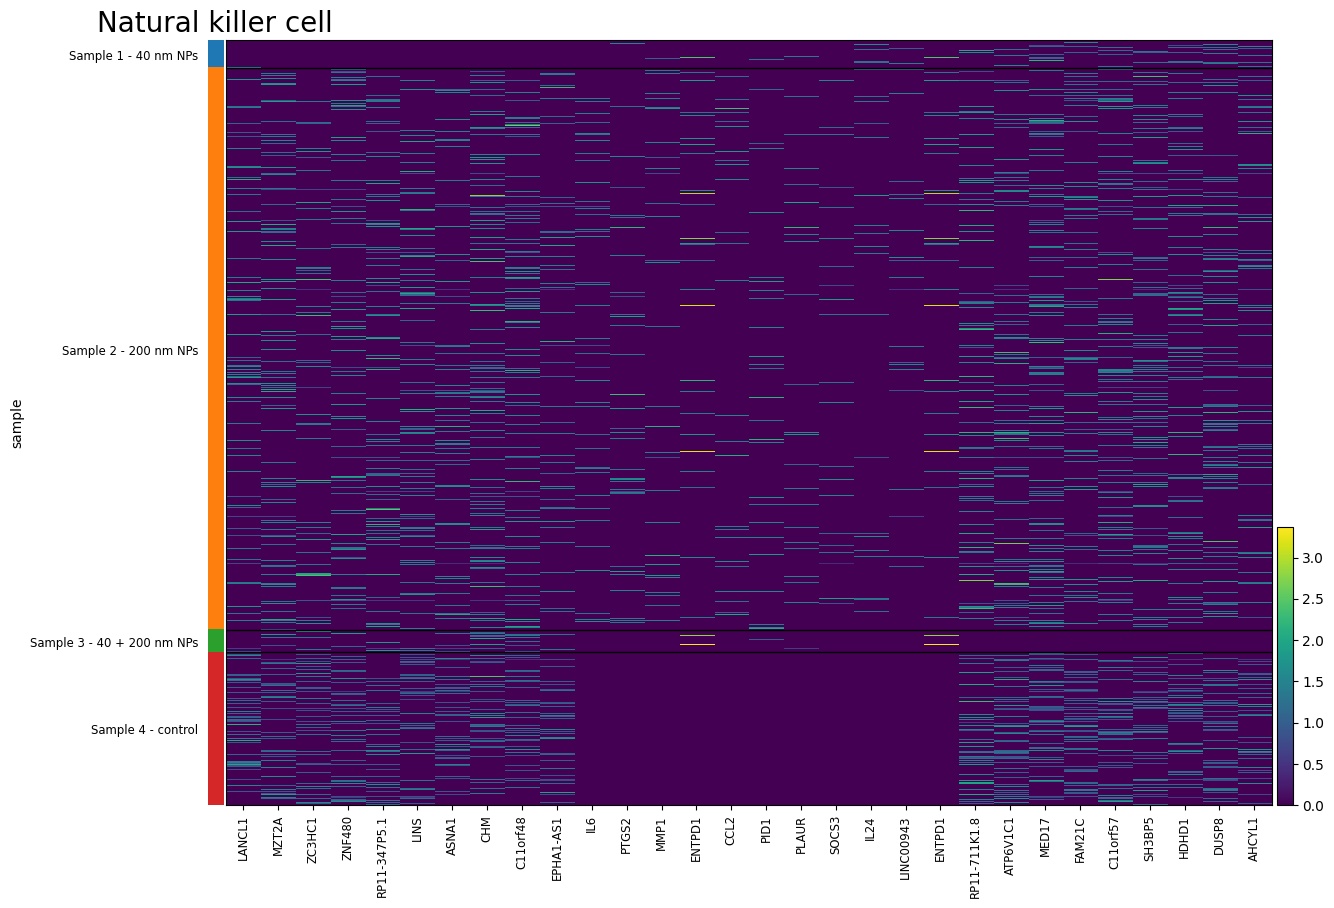

<Figure size 640x480 with 0 Axes>

In [41]:
# Create a figure for each cell type
# fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns for 4 subplots
# axes = axes.flatten()  # Flatten the 2x2 array into a 1D array for easier indexing
sample_names_dict = dict(zip(samples, sample_names))
# Loop through each cell type and plot in a subplot
for i, ct in enumerate(cell_types):
    # fig, axes = plt.subplots(1, 1, figsize=(14, 10))  # 2 rows, 2 columns for 4 subplots
    adata_subset = merged_adata[merged_adata.obs['predicted.celltype'].isin([ct])].copy()
    adata_subset.obs['sample'] = [sample_names_dict[sample] for sample in adata_subset.obs['sample']]
    sc.pp.normalize_total(adata_subset, target_sum=1e4)
    sc.pp.log1p(adata_subset)
    print(len(adata_subset))

    # Plot heatmap for top genes
    top_genes_all = np.concatenate((results_all_degs[ct]['sample_1']['names'][:10].values, 
                                   results_all_degs[ct]['sample_2']['names'][:10].values,
                                    results_all_degs[ct]['sample_3']['names'][:10].values))
    # top_genes_all = np.array([results_significant_degs[ct][sample]['names'][:10] for sample in samples[:-1]]).flatten()

    sc.pl.heatmap(
        adata_subset, 
        var_names=top_genes_all,
        groupby='sample', 
        use_raw=False,
        figsize=(14, 10),
        show=False,  # Prevent automatic display
    )
    plt.title(ct, fontsize = 20)
    plt.savefig(f'heatmap_h5_{ct}.png', dpi=150, bbox_inches='tight')
    plt.show()
    # axes[i].set_title(ct)  # Set the title for each subplot

# Adjust layout for better spacing
plt.tight_layout()

# Gene set enrichment

In [124]:
results_all_gse = {ct: dict() for ct in cell_types}
for ct, dct in results_all_degs.items():
    for sample, df in dct.items():
        ct_name = ct.replace(' ', '_')
        sheet_name = f'{ct_name}_{sample}'
        # Rank genes by log2FoldChange (use -log10(padj) to weigh significance)
        df['rank'] = df['logfoldchanges_abs'] * -np.log10(df['pvals_adj'])
        # df['rank'] += np.random.uniform(0, 1e-6 * min(df['rank']), size=len(df))  # To avoid duplicates
        df.rename(columns={'names': 'gene_name'}, inplace=True)
        # Sort by rank
        # ranked_genes = df[['gene_name', 'rank']].sort_values(by='rank', ascending=False)
        ranked_genes = df[['gene_name', 'rank']].sort_values(by=['rank', 'gene_name'], ascending=[False, True])

        # Run GSEA
        gsea_results = gp.prerank(
            rnk=ranked_genes,  # Input ranked gene list
            gene_sets='KEGG_2021_Human',  # Select gene sets
            organism='Human',
            outdir='gsea_results',  # Output folder
            permutation_num=1000,  # Number of permutations
            seed=42
        )
        # Sort GSEA results by FDR (ascending) and then NES (descending)
        sorted_gsea_df = gsea_results.res2d.sort_values(by=['FDR q-val', 'NES'], ascending=[True, False])

        # Filter significant pathways
        significant_gsea_df = sorted_gsea_df[
            (sorted_gsea_df['FDR q-val'] <= 0.05) & 
            (sorted_gsea_df['NES'].abs() >= 1.5)
        ]
        
        # Optional: Filter based on gene set size
        significant_gsea_df = significant_gsea_df[
            (significant_gsea_df['Tag %'].apply(lambda x: int(x.split('/')[0])) >= 15) & # Keep pathways with 15 to 500 genes 
            (significant_gsea_df['Tag %'].apply(lambda x: int(x.split('/')[0])) <= 500)
        ]
        results_all_gse[ct][sample] = significant_gsea_df


2024-12-15 00:06:23,235 [WARNING] Duplicated values found in preranked stats: 81.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-12-15 00:06:37,909 [WARNING] Duplicated values found in preranked stats: 80.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-12-15 00:06:51,228 [WARNING] Duplicated values found in preranked stats: 87.72% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-12-15 00:07:06,955 [WARNING] Duplicated values found in preranked stats: 81.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-12-15 00:07:21,572 [WARNING] Duplicated values found in preranked stats: 75.84% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-12-15 00:07:35,564 [WARNING] Duplicated values found in preranked stats: 91.26% of genes
The order of those genes w

In [127]:
significant_gsea_df

Name                                   Term        ES        NES  \
133  prerank       Fc gamma R-mediated phagocytosis -0.128167 -11.754138   
132  prerank                 GnRH signaling pathway -0.128228 -11.780125   
131  prerank           Choline metabolism in cancer -0.128232 -11.782447   
130  prerank                 Small cell lung cancer  -0.13144 -11.809659   
129  prerank  Phosphatidylinositol signaling system -0.128871  -11.87559   
..       ...                                    ...       ...        ...   
267  prerank      Pantothenate and CoA biosynthesis -0.149097  -3.142782   
268  prerank       Vitamin digestion and absorption -0.127434  -3.055109   
269  prerank                        Mismatch repair -0.129543  -3.036512   
270  prerank                Fatty acid biosynthesis -0.168118  -3.032013   
271  prerank        Terpenoid backbone biosynthesis -0.133207  -2.913458   

    NOM p-val FDR q-val FWER p-val  Tag %   Gene %  \
133       0.0       0.0        0.0  93/93  100.00%   
132       0.0       0.0        0.0  93/93  100.00%   
131       0.0       0.0        0.0  94/94  100.00%   
130       0.0       0.0        0.0  92/92  100.00%   
129       0.0       0.0        0.0  93/93  100.00%   
..        ...       ...        ...    ...      ...   
267  0.040363  0.038791        1.0  21/21  100.00%   
268  0.037602  0.042492        1.0  23/23  100.00%   
269  0.042381  0.043097        1.0  23/23  100.00%   
270  0.052367  0.043144        1.0  17/17  100.00%   
271  0.052525  0.048662        1.0  22/22  100.00%   

                                            Lead_genes  
133  GSN;GAB2;INPP5D;INPPL1;HCK;DOCK1;DNM2;FCGR2B;F...  
132  GRB2;HBEGF;GNA11;GNAQ;GNAS;GNRHR;GNRH2;GNRH1;H...  
131  GRB2;GPCPD1;HIF1A;HRAS;EGF;EGFR;EIF4EBP1;DGKA;...  
130  GADD45A;GADD45B;GADD45G;IKBKB;IKBKG;ITGA2;ITGA...  
129  IPPK;IP6K1;IP6K2;IP6K3;IPMK;INPP5B;INPP1;INPP4...  
..                                                 ...  
267  GADL1;ENPP1;ENPP3;DPYD;DPYS;ALDH1B1;ALDH2;ALDH...  
268  FOLH1;MMACHC;LMBRD1;LRAT;AWAT2;BTD;APOA1;APOA4...  
269  EXO1;MLH3;MLH1;MSH6;MSH2;MSH3;LIG1;RPA1;RPA2;R...  
270  HSD17B8;FASN;MCAT;MECR;ACSBG1;ACSBG2;ACSF3;ACS...  
271  GGPS1;ICMT;IDI1;IDI2;HMGCR;HMGCS1;HMGCS2;DHDDS...  

[272 rows x 10 columns]

/tmp/ipykernel_1512/1046007967.py:1: RuntimeWarning: divide by zero encountered in log10
  gsea_df['-log10(p-value)'] = gsea_df['NOM p-val'].apply(lambda x: -np.log10(x))


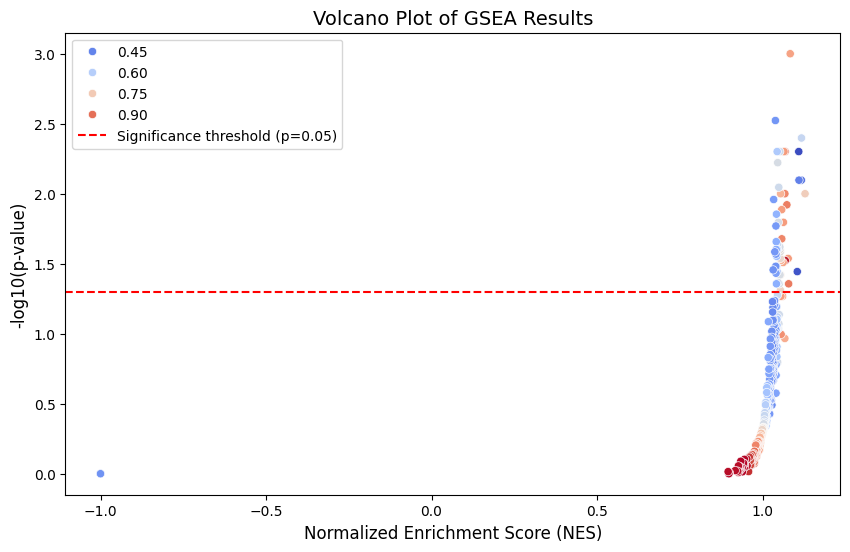

In [115]:
# gsea_df['-log10(p-value)'] = gsea_df['NOM p-val'].apply(lambda x: -np.log10(x))

# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=gsea_df, x='NES', y='-log10(p-value)', hue='FDR q-val', palette='coolwarm')
# plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='Significance threshold (p=0.05)')
# plt.xlabel('Normalized Enrichment Score (NES)', fontsize=12)
# plt.ylabel('-log10(p-value)', fontsize=12)
# plt.title('Volcano Plot of GSEA Results', fontsize=14)
# plt.legend()
# plt.show()


# Write final DEGs and GSE results to Excel

In [126]:
def write_to_excel(fname, dict_res):
    # Create an Excel writer object to save all sheets in a single file
    with pd.ExcelWriter(fname, engine='xlsxwriter') as writer:
        for ct, dct in dict_res.items():
            for sample, df in dct.items():
                ct_name = ct.replace(' ', '_')
                if 'significance' in df.columns:
                    df = df[df['significance'] != 'Not Significant']
                sheet_name = f'{ct_name}_{sample}'
                df.to_excel(writer, sheet_name=sheet_name[:31], index=False)  # Excel sheet names must be <= 31 characters
write_to_excel('de_results.xlsx', results_all_degs)
write_to_excel('gse_results.xlsx', results_all_gse)

            
# for ct, dct in results_all_degs.items():
#     for sample, df in dct.items():
#         ct_name = ct.replace(' ', '_')
#         df = df[df['significance'] != 'Not Significant']
#         df.to_csv(f'de_{ct_name}_{sample}')     